In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    

n_categories = len(all_categories)


['data/names/Scottish.txt', 'data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Irish.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt']
Slusarski


In [2]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor



print(lineToTensor('Jones').size())



torch.Size([5, 1, 57])


In [3]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i



In [7]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = English / line = Buchanan
category = Spanish / line = Ibarra
category = Arabic / line = Said
category = Czech / line = Klineberg
category = Russian / line = Balahnin
category = Dutch / line = Hautum
category = French / line = Poirier
category = Dutch / line = Roijacker
category = French / line = Proulx
category = Arabic / line = Shamon


In [8]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 3.6920 Jordan / Scottish ✗ (German)
10000 10% (0m 21s) 1.2926 Ku / Korean ✓
15000 15% (0m 32s) 1.6292 Henriques / German ✗ (Portuguese)
20000 20% (0m 43s) 1.8609 Kalogeria / Italian ✗ (Greek)
25000 25% (0m 54s) 0.2933 Chou / Korean ✓
30000 30% (1m 5s) 0.8518 Chin / Korean ✓
35000 35% (1m 16s) 0.3231 Than / Vietnamese ✓
40000 40% (1m 26s) 0.7271 Castro / Portuguese ✓
45000 45% (1m 37s) 0.6949 Seghers / Dutch ✓
50000 50% (1m 47s) 0.8746 Michalaras / Greek ✓
55000 55% (1m 58s) 0.9143 Mackenzie / Scottish ✓
60000 60% (2m 9s) 5.3715 Tracey / Czech ✗ (Irish)
65000 65% (2m 19s) 1.1657 Polites / Greek ✓
70000 70% (2m 32s) 0.4985 Truong / Vietnamese ✓
75000 75% (2m 43s) 0.6239 Spicka / Czech ✓
80000 80% (2m 54s) 0.9047 Cao / Vietnamese ✓
85000 85% (3m 5s) 0.7024 Fung / Chinese ✓
90000 90% (3m 16s) 0.8083 Sha / Chinese ✓
95000 95% (3m 27s) 1.0689 Harding / English ✓
100000 100% (3m 37s) 1.1134 Dubicki / Japanese ✗ (Polish)


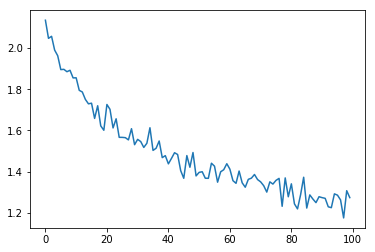

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

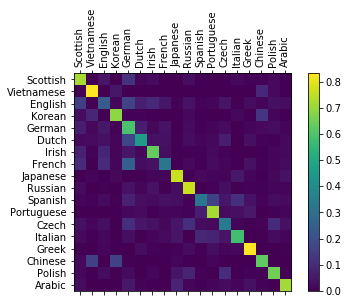

In [14]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')



> Dovesky
(-0.45) Russian
(-1.40) Czech
(-3.07) Polish

> Jackson
(-0.33) Scottish
(-1.98) English
(-2.51) Russian

> Satoshi
(-0.64) Arabic
(-1.36) Japanese
(-2.17) Polish
